### Movielens dataset으로 Learning-To-Rank 실습
> 쇼핑몰 검색엔진을 최적화한다고 생각하여 봅시다. 검색을 통해 어떻게 순위를 매겨서 차례로 노출시킬 수 있을까요?
> 직관적으로 피드백을 통해 개선하거나, A/B testing을 생각해 볼 수 있지만, 조금 더 공학적인 접근을 해보자구요 우리.


**구매전환에 대한 점수를 매겨서, likelihood를 최대화하는 방향으로 선호도 함수를 자동으로 학습하는 알고리즘을 구현해 봅시다.**

- price에 따른 구매 확률인 event data 생성
- Tree 와 Logisticregression으로 성능 측정!

[참고자료](https://towardsdatascience.com/learning-to-rank-with-python-scikit-learn-327a5cfd81f)

In [1]:
!pip install sklearn
!pip install pdb
!pip install csv
!pip install lasagne
# !pip install sklearn.cross_validation

ERROR: Could not find a version that satisfies the requirement pdb (from versions: none)
ERROR: No matching distribution found for pdb
ERROR: Could not find a version that satisfies the requirement csv (from versions: none)
ERROR: No matching distribution found for csv
ERROR: Could not find a version that satisfies the requirement sklearn.cross_validation (from versions: none)
ERROR: No matching distribution found for sklearn.cross_validation


In [46]:
import sys
sys.path.insert(0, '../lib')  # noqa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import pdb
from sklearn.metrics import *
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import itertools
import csv
# from lasagne import layers
# from lasagne.updates import nesterov_momentum
# from lasagne.nonlinearities import softmax
# from nolearn.lasagne import NeuralNet
from greedy_order import *

## 데이터 로드

In [47]:
genres_data = pd.read_csv(
    '/content/sample_data/u.genre', 
    sep = '|', 
    encoding = "ISO-8859-1", 
    header = None, 
    names=['name', 'id']
)

> 몇개의 칼럼을 append합니다.

In [48]:
movie_data_columns = np.append(
    ['movie_id', 'title', 'release_date', 'video_release_date', 'url'], 
    genres_data['name'].values
)

In [49]:
movie_data = pd.read_csv(
    '/content/sample_data/u.item', 
    sep = '|', 
    encoding = "ISO-8859-1", 
    header = None, 
    names = movie_data_columns,
    index_col = 'movie_id'
)

In [50]:

selected_columns = np.append(['title', 'release_date'], genres_data['name'].values)
movie_data = movie_data[selected_columns]
movie_data['release_date'] = pd.to_datetime(movie_data['release_date'])

movie_data.head()

,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),1995-01-01,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),1995-01-01,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),1995-01-01,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


> 영화 이름, 출시일, 장르에 관한 정보(one-hot encoding) 가 담겨있는 `movie_data` 이네요!

In [51]:
ratings_data = pd.read_csv(
    '/content/sample_data/u.data', 
    sep = '\t', 
    encoding = "ISO-8859-1", 
    header = None, 
    names=['user_id', 'movie_id', 'rating', 'timestamp']
)

In [52]:
movie_data['ratings_average'] = ratings_data.groupby(['movie_id'])['rating'].mean()
movie_data['ratings_count'] = ratings_data.groupby(['movie_id'])['rating'].count()

In [53]:
movie_data[['title', 'ratings_average', 'ratings_count']].head()

,title,ratings_average,ratings_count
movie_id,,,
1,Toy Story (1995),3.878319,452
2,GoldenEye (1995),3.206107,131
3,Four Rooms (1995),3.033333,90
4,Get Shorty (1995),3.550239,209
5,Copycat (1995),3.302326,86


> 이번에는 평점과 리뷰수가 담겨있는 데이터를 불러왔습니다. 
이제 null 값을 제거해보겠습니다.

In [54]:
movie_data[selected_columns].isnull().any()

title           False
release_date     True
unknown         False
Action          False
Adventure       False
Animation       False
Children's      False
Comedy          False
Crime           False
Documentary     False
Drama           False
Fantasy         False
Film-Noir       False
Horror          False
Musical         False
Mystery         False
Romance         False
Sci-Fi          False
Thriller        False
War             False
Western         False
dtype: bool

In [55]:
null_release_dates = movie_data[movie_data['release_date'].isnull()]
assert null_release_dates.shape[0] == 1

In [56]:
movie_data = movie_data.drop(null_release_dates.index.values)
assert movie_data[selected_columns].isnull().any().any() == False

In [57]:
movie_data.dtypes


title                      object
release_date       datetime64[ns]
unknown                     int64
Action                      int64
Adventure                   int64
Animation                   int64
Children's                  int64
Comedy                      int64
Crime                       int64
Documentary                 int64
Drama                       int64
Fantasy                     int64
Film-Noir                   int64
Horror                      int64
Musical                     int64
Mystery                     int64
Romance                     int64
Sci-Fi                      int64
Thriller                    int64
War                         int64
Western                     int64
ratings_average           float64
ratings_count               int64
dtype: object

> 여기서 영화의 가격에 대한 정보를 인위적으로  추가해 보겠습니다!

In [58]:
from datetime import datetime
import dateutil


oldest_date = pd.to_datetime(movie_data['release_date']).min()
most_recent_date = pd.to_datetime(movie_data['release_date']).max()
normalised_age = (most_recent_date - pd.to_datetime(movie_data['release_date'])) / (most_recent_date - oldest_date)
normalised_rating = (5 - movie_data['ratings_average']) / (5 - 1)

movie_data['price'] = np.round((1 - normalised_rating) * (1 - normalised_age) * 10)
movie_data[['title', 'price', 'ratings_average', 'ratings_count']].head()

,title,price,ratings_average,ratings_count
movie_id,,,,
1,Toy Story (1995),7.0,3.878319,452
2,GoldenEye (1995),5.0,3.206107,131
3,Four Rooms (1995),5.0,3.033333,90
4,Get Shorty (1995),6.0,3.550239,209
5,Copycat (1995),5.0,3.302326,86


In [59]:
# one movie had title unknown, relesease data unknown, etc...
movie_data = movie_data[movie_data['price'].notnull()]

In [60]:
# the lower the price, the more likely I am going to buy
movie_data['buy_probability'] = 1 - movie_data['price'] * 0.1

> 랭킹이 완벽하다면, 아래와 같이 그래프를 확인할 수 있습니다. **가격이 낮을수록 구매확률은  올라가겠죠!!**

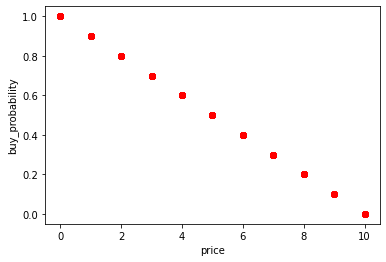

In [61]:
plt.plot(movie_data['price'].values, movie_data['buy_probability'].values, 'ro') # ro = red circles
plt.xlabel('price')
plt.ylabel('buy_probability')
plt.show()

> 장르, 년도, 평점, 가격에 대한 분포를 시각화해보겠습니다.

In [62]:
def plot_genres(movie_data):
    genres_array = [(genre, movie_data[genre].sum()) for genre in genres_data['name'].values]
    genres_names = list(map(lambda x: x[0], genres_array))
    genres_count = list(map(lambda x: x[1], genres_array))

    genres_df = pd.DataFrame({'name': genres_names, 'count': genres_count})
    x = np.arange(len(genres_df['name'].values))
    plt.bar(x, genres_df['count'].values)
    plt.xticks(x, genres_df['name'].values, rotation='vertical')
    plt.title("Genres distribution")
    
def plot_years(movie_data):
    years = movie_data['release_date'].values.astype('datetime64[Y]').astype(int) + 1970
    plt.hist(years)
    plt.title("Years distribution")
    
def plot_ratings(movie_data):
    movie_data['ratings_average'].hist()
    plt.title("Ratings distribution")
    
def plot_price(movie_data):
    movie_data['price'].hist()
    plt.title("Price distribution")
    
def plot_ratings_count(movie_data):
    movie_data['ratings_count'].hist()
    plt.title("Ratings count")
    
def buy_probability_distribution(movie_data):
    movie_data['buy_probability'].hist(bins=11)
    plt.title("Buy probability distribution")

In [63]:
def plot_distributions(movie_data):
    fig = plt.figure(figsize=(8, 6)) 

    fig.add_subplot(3, 2, 1)
    plot_genres(movie_data)

    fig.add_subplot(3, 2, 2)
    plot_years(movie_data)

    fig.add_subplot(3, 2, 3)
    plot_ratings(movie_data)

    fig.add_subplot(3, 2, 4)
    plot_price(movie_data)

    fig.add_subplot(3, 2, 5)
    plot_ratings_count(movie_data)

    fig.add_subplot(3, 2, 6)
    buy_probability_distribution(movie_data)

    plt.tight_layout()

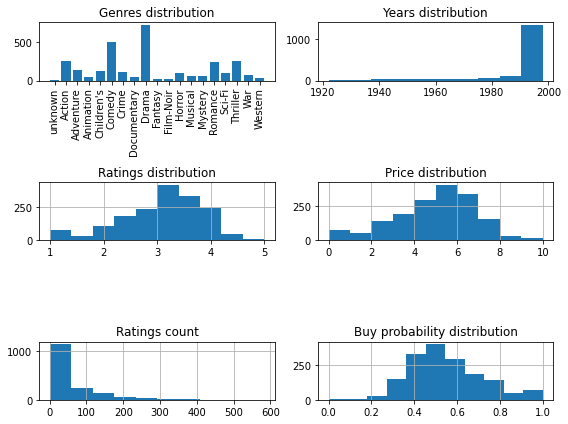

In [64]:
plot_distributions(movie_data)

## Event DataBase Function 정의하기

In [65]:

# The users database
class User:
    def __init__(self, id):
        self.id = id
        self.positive = []
        self.negative = []
        
    def add_positive(self, movie_id):
        self.positive.append(movie_id)
    
    def add_negative(self, movie_id):
        self.negative.append(movie_id)
    
    def get_positive(self):
        return self.positive
    
    def get_negative(self):
        return self.negative

## 이제 EventGenerator Class를 정의하여 사용자들의 이벤트를 생성하여 봅시다.

In [66]:
np.random.seed(1)

class EventsGenerator:
    NUM_OF_OPENED_MOVIES_PER_USER = 20
    NUM_OF_USERS = 1000

    def __init__(self, learning_data, buy_probability):
        self.learning_data = learning_data
        self.buy_probability = buy_probability
        self.users = []
        for id in range(1, self.NUM_OF_USERS):
            self.users.append(User(id))
        
    def run(self, pairwise=False):
        for user in self.users:
            opened_movies = np.random.choice(self.learning_data.index.values, self.NUM_OF_OPENED_MOVIES_PER_USER)
            self.__add_positives_and_negatives_to(user, opened_movies)

        if pairwise:
            return self.__build_pairwise_events_data()
        else:
            return self.__build_events_data()

    def __add_positives_and_negatives_to(self, user, opened_movies):
        for movie_id in opened_movies:
            if np.random.binomial(1, self.buy_probability.loc[movie_id]): 
                user.add_positive(movie_id)
            else:
                user.add_negative(movie_id)
                
    def __build_events_data(self):
        events_data = []
        
        for user in self.users:
            for positive_id in user.get_positive():
                tmp = learning_data.loc[positive_id].to_dict()
                tmp['outcome'] = 1
                events_data += [tmp]
            
            for negative_id in user.get_negative():
                tmp = learning_data.loc[negative_id].to_dict()
                tmp['outcome'] = 0
                events_data += [tmp]
                
        return pd.DataFrame(events_data)
    
    def __build_pairwise_events_data(self):
        events_data = []
        
        for i, user in enumerate(self.users):
            print("{} of {}".format(i, len(self.users)))
            positives = user.get_positive()
            negatives = user.get_negative()
            
            sample_size = min(len(positives), len(negatives))
            
            positives = np.random.choice(positives, sample_size)
            negatives = np.random.choice(negatives, sample_size)
            
            # print("Adding {} events".format(str(len(positives) * len(negatives) * 2)))
            for positive in positives:
                for negative in negatives:                    
                    e1 = learning_data.loc[positive].values
                    e2 = learning_data.loc[negative].values
                    
                    pos_neg_example = np.concatenate([e1, e2, [1]])
                    neg_pos_example = np.concatenate([e2, e1, [0]])
                    
                    events_data.append(pos_neg_example)
                    events_data.append(neg_pos_example)
        
        c1 = [ c + '_1' for c in learning_data.columns]
        c2 = [ c + '_2' for c in learning_data.columns]
        return pd.DataFrame(events_data, columns = np.concatenate([c1, c2, ['outcome']]))

In [67]:
def build_learning_data_from(movie_data):
    feature_columns = np.setdiff1d(movie_data.columns, np.array(['title', 'buy_probability']))
    learning_data = movie_data.loc[:, feature_columns]
    
    scaler = StandardScaler()
    learning_data.loc[:, ('price')] = scaler.fit_transform(learning_data[['price']])
    learning_data['ratings_average'] = scaler.fit_transform(learning_data[['ratings_average']])
    learning_data['ratings_count'] = scaler.fit_transform(learning_data[['ratings_count']])
    learning_data['release_date'] = learning_data['release_date'].apply(lambda x: x.year)
    learning_data['release_date'] = scaler.fit_transform(learning_data[['release_date']])
    
    return learning_data

In [68]:
def plot_events_distribution(events_data):
    events_data_sample = events_data.sample(frac=0.1)
    negative_outcomes = events_data_sample[events_data_sample['outcome'] == 0.0]['price']
    positive_outcomes = events_data_sample[events_data_sample['outcome'] == 1.0]['price']
    
    outcomes = np.array(list(zip(negative_outcomes.values, positive_outcomes.values)))
    plt.hist(outcomes, bins=11, label = ['Negative', 'Positive'])
    plt.legend()
    plt.xlabel('price')
    plt.show()

In [69]:
def get_feature_columns_from(learning_data, pairwise=False):
    if not pairwise:
        return learning_data.columns.values
    else:
        f1 = [c + '_1' for c in learning_data.columns.values]
        f2 = [c + '_2' for c in learning_data.columns.values]
        f1.extend(f2)
        return np.asarray(f1)

In [70]:
def save_events_data(events_data, learning_data, tag, pairwise=False):
    events_data = events_data.reindex(np.random.permutation(events_data.index))
    events_data.to_csv('movie_events_' + tag + '.csv')
    
    if not pairwise:
        df = pd.DataFrame(get_feature_columns_from(learning_data))
        df.to_csv("feature_columns_" + tag + ".csv")
    else:
        df = pd.DataFrame(get_feature_columns_from(learning_data, pairwise=True))
        df.to_csv("feature_columns_" + tag + ".csv")

In [71]:

def load_events_data(tag):
    events_data = pd.read_csv('movie_events_' + tag + '.csv')
    tmp = pd.read_csv("feature_columns_" + tag + ".csv")
    feature_columns = tmp['0'].values
    
    return [events_data, feature_columns]

In [72]:
def get_test_train_data(events_data, feature_columns):
    X = events_data.loc[:, feature_columns].values.astype(np.float32)
    print('overall input shape: ' + str(X.shape))

    y = events_data.loc[:, ['outcome']].values.astype(np.float32).ravel()
    print('overall output shape: ' + str(y.shape))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print('training input shape: ' + str(X_train.shape))
    print('training output shape: ' + str(y_train.shape))

    print('testing input shape: ' + str(X_test.shape))
    print('testing output shape: ' + str(y_test.shape))
    
    return [X_train, X_test, y_train, y_test]

In [73]:
learning_data = build_learning_data_from(movie_data)

In [74]:
events_data = EventsGenerator(learning_data, movie_data['buy_probability']).run()


In [75]:
save_events_data(events_data, learning_data, 'linear')


In [76]:
events_data, feature_columns = load_events_data('linear')


### 아래와 같이 
- 가격이 낮을수록 구매확률은 높아진다는 가정 하에 유저들의 가상의 event(구매활동)에 대한 정보를 시각화했습니다! 
### 이 값은 우리가 학습 진행시 label 데이터가 될 것입니다!!

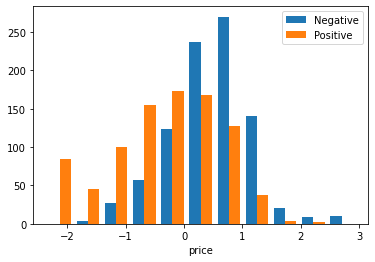

In [86]:
plot_events_distribution(events_data)


## 이제 train_test split을 통하여 구매확률을 얼마나 잘 학습할지 성능을 체크해봅시다!

In [79]:
X_train, X_test, y_train, y_test = get_test_train_data(events_data, feature_columns)


overall input shape: (19980, 23)
overall output shape: (19980,)
training input shape: (15984, 23)
training output shape: (15984,)
testing input shape: (3996, 23)
testing output shape: (3996,)


In [80]:
def train_model(model, prediction_function, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_train_pred = prediction_function(model, X_train)
    print('train precision: ' + str(precision_score(y_train, y_train_pred)))
    print('train recall: ' + str(recall_score(y_train, y_train_pred)))
    print('train accuracy: ' + str(accuracy_score(y_train, y_train_pred)))
    y_test_pred = prediction_function(model, X_test)
    print('test precision: ' + str(precision_score(y_test, y_test_pred)))
    print('test recall: ' + str(recall_score(y_test, y_test_pred)))
    print('test accuracy: ' + str(accuracy_score(y_test, y_test_pred)))
    
    return model

## 1) Logistic Regression으로 성능 측정! -> 64%의 test accuracy.

In [81]:
def get_predicted_outcome(model, data):
    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)
def get_predicted_rank(model, data):
    return model.predict_proba(data)[:, 1]
model = train_model(LogisticRegression(), get_predicted_outcome, X_train, y_train, X_test, y_test)

train precision: 0.6740188772975658
train recall: 0.7543645057266763
train accuracy: 0.6565315315315315
test precision: 0.6495925494761351
test recall: 0.7584956955142728
test accuracy: 0.6406406406406406


> 시각화 함수를 별도로 정의해 보겠습니다!!

In [78]:
def plot_rank(features, model, learning_data, predict_fun):
    lg_input = learning_data.values.astype(np.float32)
    print('overall input shape: ' + str(lg_input.shape))

    learning_data_with_rank = learning_data.copy()
    learning_data_with_rank['rank'] = predict_fun(model, lg_input)
    
    for idx, feature in enumerate(features):
        plt.subplot(len(features), 1, idx + 1)
        plt.plot(learning_data_with_rank[feature].values, learning_data_with_rank['rank'].values, 'ro')
        plt.xlabel(feature)
        plt.ylabel('rank')
        
    plt.tight_layout()
    plt.show()

overall input shape: (1681, 23)


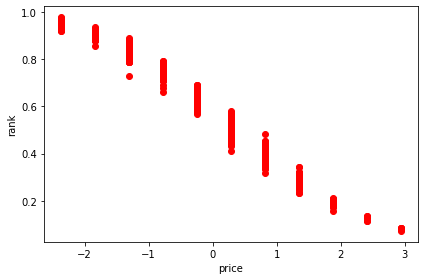

In [82]:
plot_rank(['price'], model, learning_data, get_predicted_rank)

In [83]:
def get_predicted_outcome(model, data):
    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)
def get_predicted_rank(model, data):
    return model.predict_proba(data)[:, 1]

## 2) Decision Tree로 성능 측정! 62%의 Test Accuracy.

In [84]:
from sklearn import tree
model = train_model(tree.DecisionTreeClassifier(), get_predicted_outcome, X_train, y_train, X_test, y_test)

train precision: 0.7404352806414662
train recall: 0.7187812743244746
train accuracy: 0.7000125125125125
test precision: 0.6590805644060082
test recall: 0.6560942455822383
test accuracy: 0.6226226226226226


overall input shape: (1681, 23)


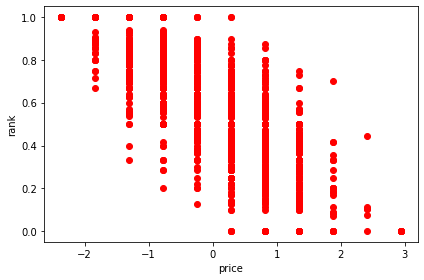

In [85]:
plot_rank(['price'], model, learning_data, get_predicted_rank)

각각 62, 65% 의 정확도를 보였네요. 추가적으로 더 제대로 된 모델을 통해서 진행하면 재밌는 결과가 나올지도 모르겠습니다.